Churn prediction
-------------------
Company churn occurs when companies cancel subscriptions or subscriptions expires without renewals.  
This notebook uses XGBoost to predict Churn, and Hyperopt for hyperparameter tuning.

**Note:**
- All data
- registered_only = True

In [0]:
import mlflow
import mlflow.sklearn
from datetime import datetime

mlflow.set_experiment("/Users/bxing@actsoft.com/Churn/Imbalance/Churn_Imbalance_XGB_All_Hyperopt_SHAP")

# date that license deactivation will check against in determinding churn or no-churn,
# usually the date that data storage was created.
pred_datetime = datetime(2020, 1, 1)
mlflow.log_param("End date", pred_datetime)

# start datetime for license activation.
start_dateime = datetime(2000, 1, 1)
mlflow.log_param("Start date", start_dateime)

# include both registered and non registered users
registered_only = True
mlflow.log_param("Setup complete", registered_only)

# scoring
# scoring = 'roc_auc'
# scoring = None
# mlflow.log_param("scoring", scoring)

# over-sample minority and under-sample majority
over_sample = False 
under_sample = False
mlflow.log_param("over_sample", over_sample)
mlflow.log_param("under_sample", under_sample)

In [0]:
%run /Users/bxing@actsoft.com/Churn/Churn_Dataframe

In [0]:
df['InstanceId'].value_counts()

Out[40]: 50 3281
53 821
Name: InstanceId, dtype: int64

all companies with licenses: 13417

In [0]:
mlflow.log_param("Instances", df['InstanceId'].value_counts())

More filtering before modeling

In [0]:
# categorical_features = ["IsSetupComplete", Tier", "UserIntegrationType"]
if registered_only:
  categorical_features = ["Tier", "UserIntegrationType"]

Categorical feature distributions

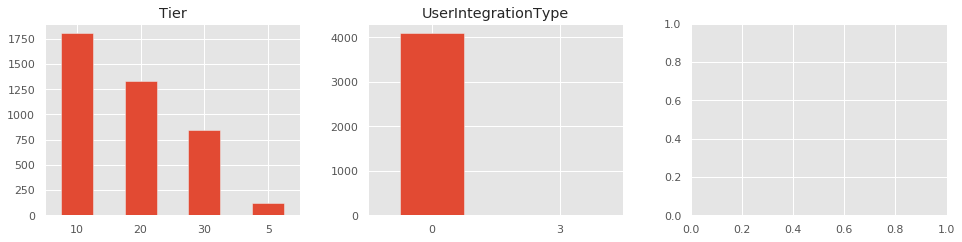

In [0]:
plt.style.use('ggplot')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, categorical_feature in enumerate(categorical_features):
  df[categorical_feature].value_counts().plot(kind='bar', ax=ax[i], rot=0).set_title(categorical_feature)

fig.tight_layout(pad=3.0)

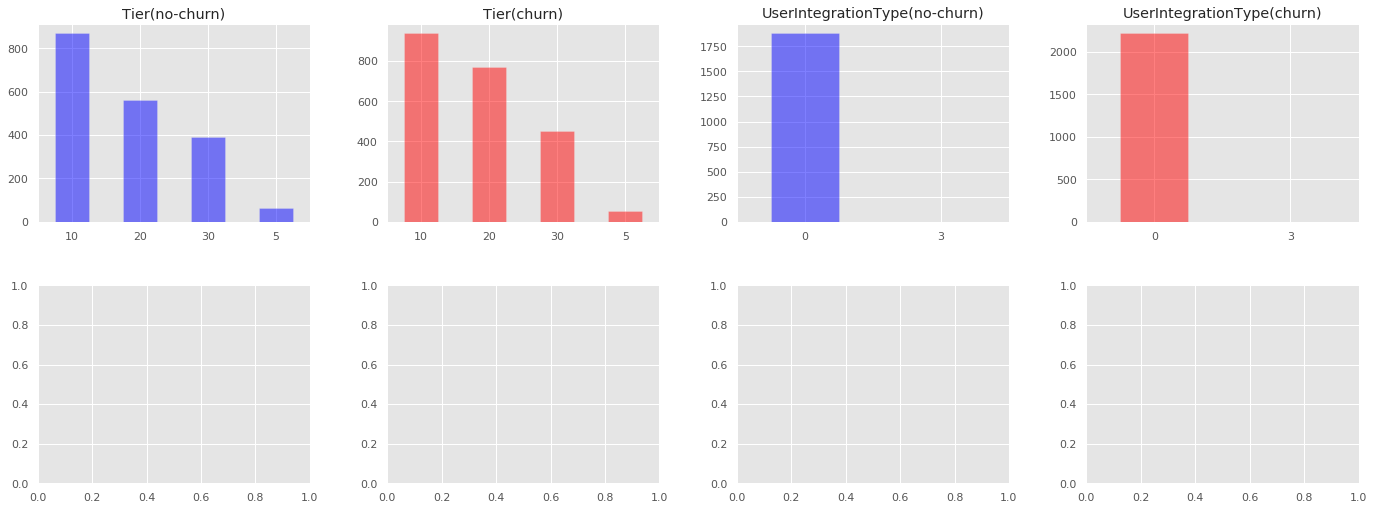

In [0]:
plt.style.use('ggplot')

# 2 row 4 col
fig, ax = plt.subplots(2, 4, figsize=(20, 8))

df[df.Churn == False]['Tier'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 0], rot=0).set_title('Tier(no-churn)')
df[df.Churn == True]['Tier'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 1], rot=0).set_title('Tier(churn)')

df[df.Churn == False]['UserIntegrationType'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 2], rot=0).set_title('UserIntegrationType(no-churn)')
df[df.Churn == True]['UserIntegrationType'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 3], rot=0).set_title('UserIntegrationType(churn)')

if registered_only == False:
  df[df.Churn == False]['IsSetupComplete'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[1, 0], rot=0).set_title('IsSetupComplete(no-churn)')
  df[df.Churn == True]['IsSetupComplete'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[1, 1], rot=0).set_title('IsSetupComplete(churn)')
  
fig.tight_layout(pad=4.0)


Numerical feature distributions

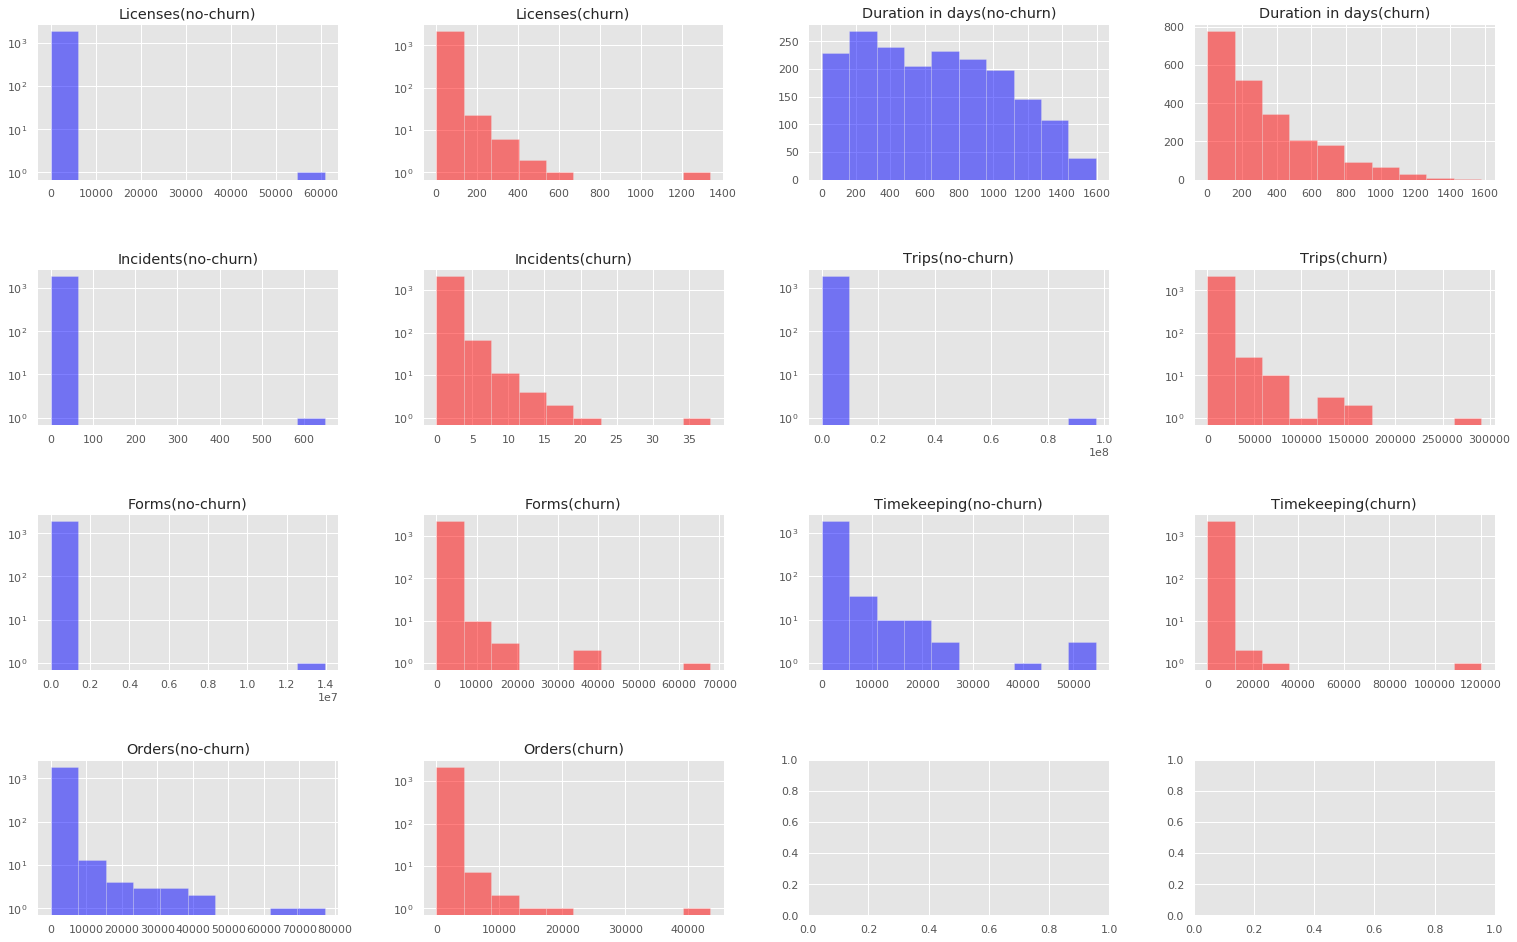

In [0]:
# numerical_features = ["Licenses", "Duration", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]

plt.style.use('ggplot')

rows, columns = 4, 4
fig, ax = plt.subplots(rows, columns, figsize=(22, 14))

df[df.Churn == False]["Licenses"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 0]).set_title("Licenses(no-churn)")
df[df.Churn == True]["Licenses"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 1]).set_title("Licenses(churn)")
ax[0, 0].set_yscale('log')
ax[0, 1].set_yscale('log')

df[df.Churn == False]["Duration"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 2]).set_title("Duration in days(no-churn)")
df[df.Churn == True]["Duration"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 3]).set_title("Duration in days(churn)")

df[df.Churn == False]["Incidents"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 0]).set_title("Incidents(no-churn)")
df[df.Churn == True]["Incidents"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 1]).set_title("Incidents(churn)")
ax[1, 0].set_yscale('log')
ax[1, 1].set_yscale('log')

df[df.Churn == False]["Trips"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 2]).set_title("Trips(no-churn)")
df[df.Churn == True]["Trips"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 3]).set_title("Trips(churn)")
ax[1, 2].set_yscale('log')
ax[1, 3].set_yscale('log')

df[df.Churn == False]["Forms"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 0]).set_title("Forms(no-churn)")
df[df.Churn == True]["Forms"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 1]).set_title("Forms(churn)")
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')

df[df.Churn == False]["Timekeeping"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 2]).set_title("Timekeeping(no-churn)")
df[df.Churn == True]["Timekeeping"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 3]).set_title("Timekeeping(churn)")
ax[2, 2].set_yscale('log')
ax[2, 3].set_yscale('log')

df[df.Churn == False]["Orders"].hist(bins=10, color="blue", alpha=0.5, ax=ax[3, 0]).set_title("Orders(no-churn)")
df[df.Churn == True]["Orders"].hist(bins=10, color="red", alpha=0.5, ax=ax[3, 1]).set_title("Orders(churn)")
ax[3, 0].set_yscale('log')
ax[3, 1].set_yscale('log')

fig.tight_layout(pad=4.0)

In [0]:
#***** FOR test only ******
df_test = df[df['Deactivation'].isnull()]
df_test_input = df_test[categorical_features + numerical_features]
df_test_input.shape

Out[46]: (1398, 9)

Correlation Matrix and Heatmap

In [0]:
df_final = df[categorical_features + [target] + numerical_features]

df_final.corr()

Out[47]:

,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
Tier,1.000000,-0.020018,0.030242,-0.014002,0.005116,-0.003796,-0.014767,-0.010614,0.086202,0.110008
UserIntegrationType,-0.020018,1.000000,-0.001826,0.005332,0.030986,-0.002677,-0.000487,-0.000442,-0.002983,-0.002359
Churn,0.030242,-0.001826,1.000000,-0.032584,-0.422801,-0.074870,-0.021854,-0.020675,-0.071779,-0.077581
Licenses,-0.014002,0.005332,-0.032584,1.000000,0.037847,0.968066,0.995813,0.994707,0.018802,0.005280
Duration,0.005116,0.030986,-0.422801,0.037847,1.000000,0.068076,0.029195,0.028697,0.103458,0.110937
Incidents,-0.003796,-0.002677,-0.074870,0.968066,0.068076,1.000000,0.967435,0.966868,0.037338,0.038852
Trips,-0.014767,-0.000487,-0.021854,0.995813,0.029195,0.967435,1.000000,0.998993,0.008464,0.001478
Forms,-0.010614,-0.000442,-0.020675,0.994707,0.028697,0.966868,0.998993,1.000000,0.009308,0.001911
Timekeeping,0.086202,-0.002983,-0.071779,0.018802,0.103458,0.037338,0.008464,0.009308,1.000000,0.107996
Orders,0.110008,-0.002359,-0.077581,0.005280,0.110937,0.038852,0.001478,0.001911,0.107996,1.000000


Out[48]:

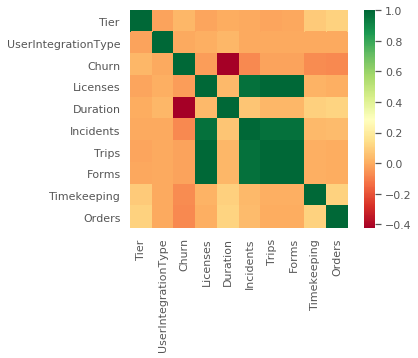

<matplotlib.axes._subplots.AxesSubplot at 0x7ff1a4fa2590>

In [0]:
sns.heatmap(df_final.corr(), square=True, cmap='RdYlGn')

In [0]:
df_final.describe(include='all')

Out[49]:

,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
count,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4102.000000,4.102000e+03,4.102000e+03,4102.000000,4102.000000
mean,17.219649,0.001463,0.541199,49.195758,482.533886,1.268893,3.340742e+04,4.361554e+03,403.130912,273.235982
std,7.966418,0.066235,0.498360,954.065487,378.863793,10.469011,1.514240e+06,2.179420e+05,2985.049515,2558.567155
min,5.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,10.000000,0.000000,0.000000,6.000000,163.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,20.000000,0.000000,1.000000,13.000000,383.000000,0.000000,1.680000e+02,0.000000e+00,0.000000,0.000000
75%,20.000000,0.000000,1.000000,29.000000,738.500000,1.000000,5.286000e+03,4.000000e+00,5.000000,0.000000
max,30.000000,3.000000,1.000000,60810.000000,1595.000000,649.000000,9.692331e+07,1.394515e+07,120322.000000,77193.000000


Create dummy variables for categorical variables

In [0]:
# cat_vars=['IsSetupComplete','Tier','UserIntegrationType']
# for var in cat_vars:
#     cat_list='var'+'_'+var
#     cat_list = pd.get_dummies(df[var], prefix=var)
#     df1=df.join(cat_list)
#     df=df1
    
# df_vars=df.columns.values.tolist()
# to_keep=[i for i in df_vars if i not in cat_vars]
# df_final=df[to_keep]
# df_final.columns.values

In [0]:
df_final.head()

Out[51]:

,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
0,10,0,0,9,1441,0,2819,0,66,0
1,30,0,0,43,1435,0,0,5,4,521
2,10,0,0,17,674,7,16293,1,0,0
3,10,0,1,8,211,0,922,0,0,0
4,10,0,1,34,657,0,16683,2,0,6


In [0]:
mlflow.log_param("dataset shape", df_final.shape)

**Training**

In [0]:
# --- training with SMOTE ---
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks

X = df_final.loc[:, df_final.columns != 'Churn']
y = df_final.loc[:, df_final.columns == 'Churn']

# SMOTENC is the only one that handles categorical values.
oversample = SMOTENC(k_neighbors=1, random_state=0, sampling_strategy=0.3, categorical_features=[0,1,2])
# oversample = SMOTENC(random_state=0, categorical_features=[0,1,2])

# under-sample
undersample = TomekLinks()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
columns = X_train.columns

if over_sample:
  data_X, data_y = oversample.fit_sample(X_train, y_train)
  X_train = pd.DataFrame(data=data_X,columns=columns )
  y_train = pd.DataFrame(data=data_y,columns=['Churn'])
  
if under_sample:
  data_X, data_y = undersample.fit_sample(X_train, y_train)
  X_train = pd.DataFrame(data=data_X,columns=columns )
  y_train = pd.DataFrame(data=data_y,columns=['Churn'])

# we can Check the numbers of our data
print("length of data is ",len(X_train))
print("Number of no churn in  data",len(y_train[y_train['Churn']==0]))
print("Number of churn",len(y_train[y_train['Churn']==1]))
print("Proportion of no churn data in data is ",len(y_train[y_train['Churn']==0])/len(X_train))
print("Proportion of churn data in data is ",len(y_train[y_train['Churn']==1])/len(X_train))


length of data is 3076
Number of no churn in data 1386
Number of churn 1690
Proportion of no churn data in data is 0.4505851755526658
Proportion of churn data in data is 0.5494148244473342

In [0]:
# training the model
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
  
# define space
space = {
    # complexity
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "min_child_weight": hp.uniform("min_child_weight", 0.5, 2),
    "gamma": hp.uniform("gamma", 1, 9),
    "n_estimators": hp.quniform("n_estimators", 100, 150, 1), # default 100
    # noise
    "learning_rate": hp.uniform("learning_rate", 0.03, 0.2), # default 0.1    
    "subsample": hp.uniform("subsample", 0.6, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1),
    # imbalance
    "scale_pos_weight": hp.uniform("scale_pos_weight", 0.3, 2)
}

# define objective func
def hyperparameter_tuning(space):
    model = XGBClassifier(n_estimators = int(space['n_estimators']), 
                          max_depth = int(space['max_depth']), 
                          min_child_weight = space['min_child_weight'],
                          gamma = space['gamma'],
                          learning_rate = space['learning_rate'],
                          subsample = space['subsample'],
                          colsample_bytree = space['colsample_bytree'],
                          scale_pos_weight = space['scale_pos_weight'],
                          random_state = 42)
    
    evaluation = [(X_train, np.ravel(y_train)), (X_test, np.ravel(y_test))]
    
    model.fit(X_train, np.ravel(y_train),
            eval_set=evaluation, eval_metric="auc", #error, (default)
            early_stopping_rounds=10,verbose=False)

#     accuracies = cross_val_score(estimator = model, X = X_train, y = np.ravel(y_train), cv = 5, scoring=scoring)
#     accuracy = accuracies.mean()
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
#     accuracy = roc_auc_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    #change the metric if you like
    return {'loss': 1-accuracy, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials,
            rstate=np.random.RandomState(42))

print (best)

/databricks/python/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
 from imp import reload
 0%| | 0/200 [00:00<?, ?trial/s, best loss=?] SCORE:
 0%| | 0/200 [00:00<?, ?trial/s, best loss=?] 0.7241715399610137
 0%| | 0/200 [00:00<?, ?trial/s, best loss=?] 0%| | 1/200 [00:00<00:33, 5.89trial/s, best loss: 0.2758284600389863] SCORE:
 0%| | 1/200 [00:00<00:33, 5.89trial/s, best loss: 0.2758284600389863] 0.7348927875243665
 0%| | 1/200 [00:00<00:33, 5.89trial/s, best loss: 0.2758284600389863] SCORE:
 1%| | 2/200 [00:00<00:33, 5.89trial/s, best loss: 0.2651072124756335] 0.7270955165692008
 1%| | 2/200 [00:00<00:33, 5.89trial/s, best loss: 0.2651072124756335] 2%|▏ | 3/200 [00:00<00:32, 6.13trial/s, best loss: 0.2651072124756335] SCORE:
 2%|▏ | 3/200 [00:00<00:32, 6.13trial/s, best loss: 0.2651072124756335] 0.7251461988304093
 2%|▏ | 3/200 [00:00<00:32, 6.13trial/s, best loss: 0.2651072124756335] SCORE:
 2%|▏ | 4/200 [00:00<00:31, 6.13trial/s, best loss: 0.2651072124756335] 0.7417153996101364
 2%|▏ | 4/200 [00:00<00:31, 6.13trial/s, best loss: 0.2651072124756335] 2%|▎ | 5/200 [00:00<00:28, 6.91trial/s, best loss: 0.25828460038986356] SCORE:
 2%|▎ | 5/200 [00:00<00:28, 6.91trial/s, best loss: 0.25828460038986356] 0.7485380116959064
 2%|▎ | 5/200 [00:00<00:28, 6.91trial/s, best loss: 0.25828460038986356] 3%|▎ | 6/200 [00:00<00:31, 6.21trial/s, best loss: 0.2514619883040936]  SCORE:
 3%|▎ | 6/200 [00:01<00:31, 6.21trial/s, best loss: 0.2514619883040936] 0.7241715399610137
 3%|▎ | 6/200 [00:01<00:31, 6.21trial/s, best loss: 0.2514619883040936] 4%|▎ | 7/200 [00:01<00:33, 5.73trial/s, best loss: 0.2514619883040936] SCORE:
 4%|▎ | 7/200 [00:01<00:33, 5.73trial/s, best loss: 0.2514619883040936] 0.7348927875243665
 4%|▎ | 7/200 [00:01<00:33, 5.73trial/s, best loss: 0.2514619883040936] SCORE:
 4%|▍ | 8/200 [00:01<00:33, 5.73trial/s, best loss: 0.2514619883040936] 0.7183235867446394
 4%|▍ | 8/200 [00:01<00:33, 5.73trial/s, best loss: 0.2514619883040936] 4%|▍ | 9/200 [00:01<00:28, 6.62trial/s, best loss: 0.2514619883040936] SCORE:
 4%|▍ | 9/200 [00:01<00:28, 6.62trial/s, best loss: 0.2514619883040936] 0.7378167641325536
 4%|▍ | 9/200 [00:01<00:28, 6.62trial/s, best loss: 0.2514619883040936] SCORE:
 5%|▌ | 10/200 [00:01<00:28, 6.62trial/s, best loss: 0.2514619883040936] 0.7153996101364523
 5%|▌ | 10/200 [00:01<00:28, 6.62trial/s, best loss: 0.2514619883040936] 6%|▌ | 11/200 [00:01<00:24, 7.67trial/s, best loss: 0.2514619883040936] SCORE:
 6%|▌ | 11/200 [00:01<00:24, 7.67trial/s, best loss: 0.2514619883040936] 0.7553606237816765
 6%|▌ | 11/200 [00:01<00:24, 7.67trial/s, best loss: 0.2514619883040936] 6%|▌ | 12/200 [00:01<00:23, 7.97trial/s, best loss: 0.24463937621832355] SCORE:
 6%|▌ | 12/200 [00:01<00:23, 7.97trial/s, best loss: 0.24463937621832355] 0.7426900584795322
 6%|▌ | 12/200 [00:01<00:23, 7.97trial/s, best loss: 0.24463937621832355] SCORE:
 6%|▋ | 13/200 [00:01<00:23, 7.97trial/s, best loss: 0.24463937621832355] 0.7173489278752436
 6%|▋ | 13/200 [00:01<00:23, 7.97trial/s, best loss: 0.24463937621832355] 7%|▋ | 14/200 [00:01<00:22, 8.31trial/s, best loss: 0.24463937621832355] SCORE:
 7%|▋ | 14/200 [00:01<00:22, 8.31trial/s, best loss: 0.24463937621832355] 0.7144249512670565
 7%|▋ | 14/200 [00:01<00:22, 8.31trial/s, best loss: 0.24463937621832355] SCORE:
 8%|▊ | 15/200 [00:01<00:22, 8.31trial/s, best loss: 0.24463937621832355] 0.7319688109161794
 8%|▊ | 15/200 [00:01<00:22, 8.31trial/s, best loss: 0.24463937621832355] 8%|▊ | 16/200 [00:01<00:18, 9.85trial/s, best loss: 0.24463937621832355] SCORE:
 8%|▊ | 16/200 [00:01<00:18, 9.85trial/s, best loss: 0.24463937621832355] 0.7426900584795322
 8%|▊ | 16/200 [00:01<00:18, 9.85trial/s, best loss: 0.24463937621832355] SCORE:
 8%|▊ | 17/200 [00:02<00:18, 9.

Use best model to get all metrics

In [0]:
# clf = XGBClassifier(random_state=42)

# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# mlflow.log_param("RepeatedStratifiedKFold", cv)

# # ****** GridSearchCV *************
# param_grid = {
#     # complexity
#     "max_depth": [int(best["max_depth"])],
#     "min_child_weight": [best["min_child_weight"]],
#     "gamma":  [best["gamma"]],
#     "n_estimators":  [int(best["n_estimators"])],
#     # noise
#     "learning_rate":  [best["learning_rate"]],   
#     "subsample":  [best["subsample"]],
#     "colsample_bytree":  [best["colsample_bytree"]],
#     # imbalance
#     "scale_pos_weight":  [best["scale_pos_weight"]]
# }

# tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv, scoring=scoring)
# # tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv)
# tree_cv.fit(X_train, np.ravel(y_train))
# pred = tree_cv.predict(X_test)

# print("Tuned XGBoost: {}".format(tree_cv.best_params_))
# print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(tree_cv.score(X_test, y_test)))

# # Log mlflow attributes for mlflow UI
# mlflow.log_param("hyperparameters", tree_cv.best_params_)
# mlflow.sklearn.log_model(tree_cv, "model")
# mlflow.log_metric("accuracy", tree_cv.score(X_test, y_test))

In [0]:
best_params = {
    # complexity
    "max_depth": int(best["max_depth"]),
    "min_child_weight": best["min_child_weight"],
    "gamma": best["gamma"],
    "n_estimators": int(best["n_estimators"]),
    # noise
    "learning_rate": best["learning_rate"],   
    "subsample": best["subsample"],
    "colsample_bytree": best["colsample_bytree"],
    # imbalance
    "scale_pos_weight": best["scale_pos_weight"],
    "random_state": 42
}

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, np.ravel(y_train))
pred = best_model.predict(X_test)

print("Tuned XGBoost: {}".format(best_params))
accuracy = accuracy_score(y_test, pred>0.5)
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(accuracy))

# Log mlflow attributes for mlflow UI
mlflow.log_param("hyperparameters", best_params)
mlflow.log_metric("accuracy", accuracy)

Tuned XGBoost: {'max_depth': 4, 'min_child_weight': 1.4906769428618978, 'gamma': 2.427763276218726, 'n_estimators': 116, 'learning_rate': 0.19194109822875222, 'subsample': 0.8306999199956985, 'colsample_bytree': 0.8230862903642684, 'scale_pos_weight': 0.6171613824901966, 'random_state': 42}
Accuracy of XGBoost classifier on test set: 0.76

In [0]:
# **** FOR TEST only*****
pred_test = best_model.predict(df_test_input)

condition = (pred_test == 0)
noChurn = np.extract(condition, pred_test) 

condition = (pred_test == 1)
churn = np.extract(condition, pred_test) 
print('churn data is ', len(churn))
print('proporation of churn data ', len(churn)/len(pred_test))

churn data is 207
proporation of churn data 0.148068669527897

Log the model to the registry for deployment

In [0]:
# sklearn model wrapper
class ModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

wrappedModel = ModelWrapper(best_model)
mlflow.pyfunc.log_model("XGBClassifier_model", python_model=wrappedModel)

**Testing **

In [0]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score

# print(classification_report(y_test, pred, labels=np.unique(pred), zero_division=0))
print(classification_report(y_test, pred))

precision recall f1-score support

 0 0.73 0.79 0.76 496
 1 0.79 0.73 0.76 530

 accuracy 0.76 1026
 macro avg 0.76 0.76 0.76 1026
weighted avg 0.76 0.76 0.76 1026

In [0]:
condition = (pred == 0)
noChurn = np.extract(condition, pred) 
print('no churn data is ', len(noChurn))

condition = (pred == 1)
churn = np.extract(condition, pred) 
print('churn data is ', len(churn))
print('proporation of churn data ', len(churn)/len(pred))

no churn data is 531
churn data is 495
proporation of churn data 0.4824561403508772

In [0]:
report = classification_report(y_test, pred, output_dict=True)
# an easy workaround to log dictionary (nested) since log_metric doesn't support it.
mlflow.log_params(report)

**Model Interpretation**

In [0]:
model = best_model
class_names = [str(el) for el in model.classes_]
feature_names = categorical_features + numerical_features

print(model)
print("Feature names: {}".format(feature_names))
print("Class names: {}".format(class_names))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 colsample_bynode=1, colsample_bytree=0.8230862903642684,
 gamma=2.427763276218726, gpu_id=-1, importance_type='gain',
 interaction_constraints='', learning_rate=0.19194109822875222,
 max_delta_step=0, max_depth=4,
 min_child_weight=1.4906769428618978, missing=nan,
 monotone_constraints='()', n_estimators=116, n_jobs=0,
 num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
 scale_pos_weight=0.6171613824901966, subsample=0.8306999199956985,
 tree_method='exact', validate_parameters=1, verbosity=None)
Feature names: ['Tier', 'UserIntegrationType', 'Licenses', 'Duration', 'Incidents', 'Trips', 'Forms', 'Timekeeping', 'Orders']
Class names: ['0', '1']

The following feature importances are not exactly same as SHAP. Be careful in their interpretation.    
The detailed reference can be found [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=importance_type). A good review can be found [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7).  

**"gain" types are most important: total gain & average gain across all trees.**

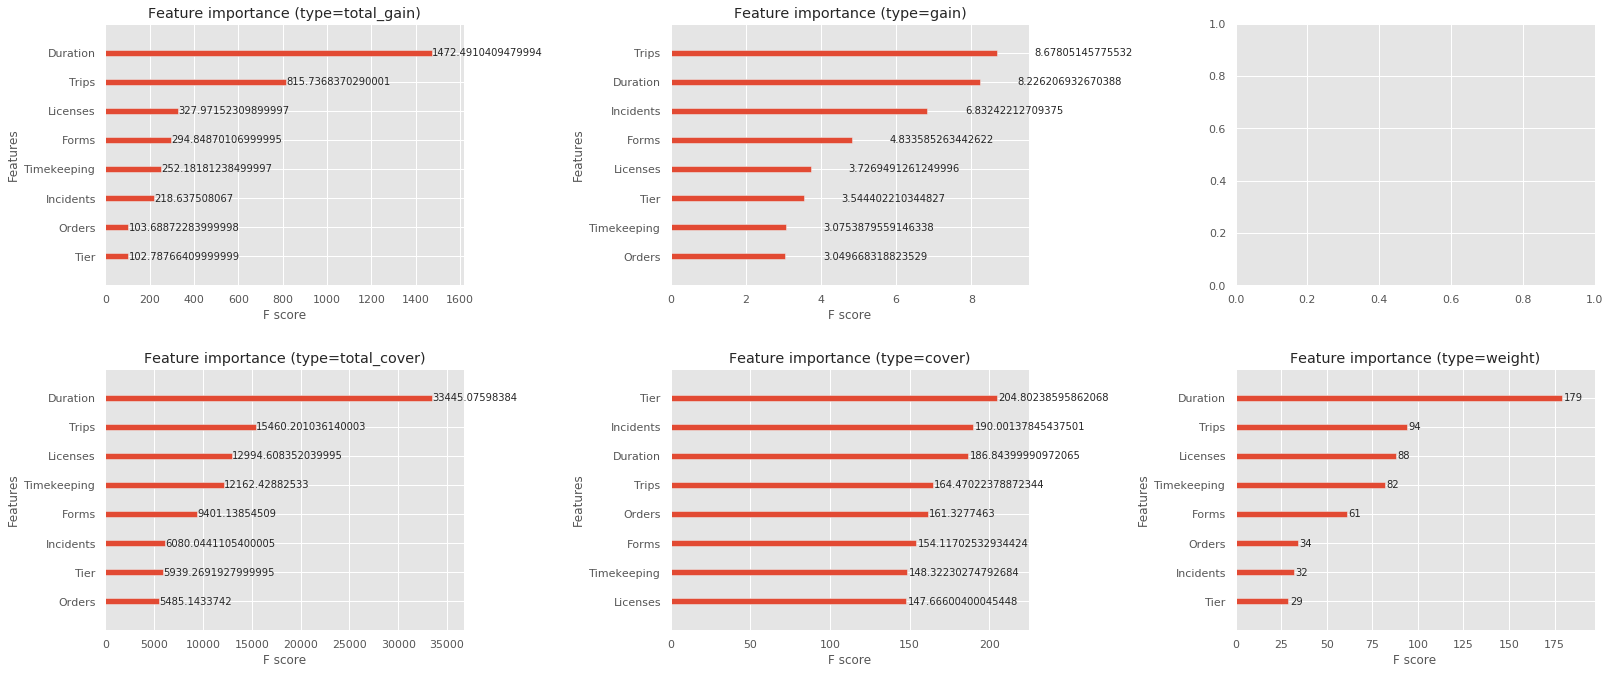

In [0]:
from xgboost import plot_importance

plt.style.use('ggplot')

fig, ax = plt.subplots(2, 3, figsize=(23, 10))

plot_importance(model, importance_type="total_gain", ax=ax[0,0])
ax[0,0].set_title('Feature importance (type=total_gain)')

plot_importance(model, importance_type="gain", ax=ax[0,1])
ax[0,1].set_title('Feature importance (type=gain)')

plot_importance(model, importance_type="total_cover", ax=ax[1,0])
ax[1,0].set_title('Feature importance (type=total_cover)')

plot_importance(model, importance_type="cover", ax=ax[1,1])
ax[1,1].set_title('Feature importance (type=cover)')

plot_importance(model, importance_type="weight", ax=ax[1,2])
ax[1,2].set_title('Feature importance (type=weight)')

fig.tight_layout(pad=3.0)

ROC Curve for test data

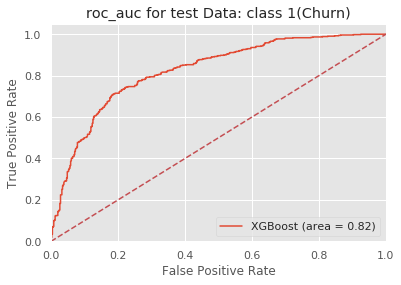

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

tree_roc_auc = roc_auc_score(y_test, best_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
mlflow.log_metric("roc_auc for class 1 test data", roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc_auc for test Data: class 1(Churn)')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()


ROC Curve for train data

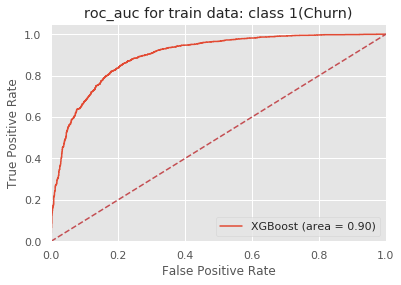

In [0]:
tree_roc_auc = roc_auc_score(y_train, best_model.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, best_model.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)
mlflow.log_metric("roc_auc for class 1 train data", roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc_auc for train data: class 1(Churn)')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

roc_auc for traning data is 0.85, and 0.81 for test data. It is the decent fit.

In [0]:
mlflow.end_run()